<a href="https://colab.research.google.com/github/fireball412/colab_experiments/blob/main/keras_frsky_voltage_current_throttle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battery model

script adapted from TinyML code example

## Configure Defaults

In [2]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [1]:
!pip install tensorflow==2.4.0rc0
!pip install -q -U keras-tuner

# required for auto-sklearn, does cause warnings for TF and keras
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install -U scikit-learn
!pip install auto-sklearn
#start "runtime new" after installation


     |████████████████████████████████| 394.7MB 40kB/s 
     |████████████████████████████████| 460kB 45.0MB/s 
     |████████████████████████████████| 1.3MB 40.4MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


     |████████████████████████████████| 71kB 3.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,298 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debcon

Import Dependencies

In [4]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# Math is Python's math library
import math


import sklearn.metrics
import autosklearn.regression

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)





## Dataset

### 1. Import Data

In [5]:
#for local file upload

#from google.colab import files 
#uploaded = files.upload()

In [5]:
import pandas as pd 
import io 

#for local file upload instead of github
#df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 

url1 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-11-28.csv'
url2 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-12-05.csv'
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

df=df1
df=df.append(df2)

#df=df1
print(df)


             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
15084  2020-12-05  14:59:43.030        77  ...  -1  0x0000000000000000       9.8
15085  2020-12-05  14:59:43.130        77  ...  -1  0x0000000000000000       9.8
15086  2020-12-05  14:59:43.230        77  ...  -1  0x0000000000000000       9.8
15087  2020-12-05  14:59:43.330        77  ...  -1  0x0000000000000000       9.8
15088  2020-12-05  14:59:43.430        77  ...  -1  0x0000000000000000       9.8

[32026 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [4]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(27844, 26)

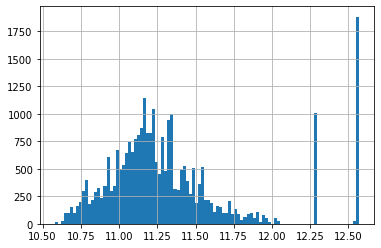

In [6]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWVOL=1
HIGHVOL=16
ind_lowvol = df[df['Cels(V)'] < LOWVOL].index
df_nolowvol = df.drop(ind_lowvol, axis=0)

ind_highvol = df[df['Cels(V)'] > HIGHVOL].index
df_nolowvol_nohighvol = df_nolowvol.drop(ind_highvol, axis=0)

df_nolowvol_nohighvol['Cels(V)'].hist(bins=100)
df_nolowvol_nohighvol['Cels(V)'].describe()

df=df_nolowvol_nohighvol
np.shape(df)

(27844, 26)

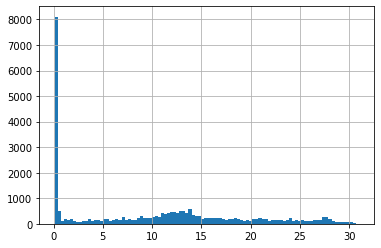

In [7]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWCUR=0
HIGHCUR=35
ind_lowcur = df[df['Curr(A)'] < LOWCUR].index
df_nolowcur = df.drop(ind_lowcur, axis=0)

ind_highcur = df[df['Curr(A)'] > HIGHCUR].index
df_nolowcur_nohighcur = df_nolowcur.drop(ind_highcur, axis=0)

df_nolowcur_nohighcur['Curr(A)'].hist(bins=100)
df_nolowcur_nohighcur['Curr(A)'].describe()

df=df_nolowcur_nohighcur
np.shape(df)


### 2. Select Data

[-1.021 -1.021 -1.022 ... -0.038 -0.036 -0.035]
[0.003 0.003 0.003 ... 0.071 0.085 0.085]
[0.    0.    0.    ... 1.272 1.273 1.273]
[1.229 1.229 1.229 ... 1.117 1.117 1.117]


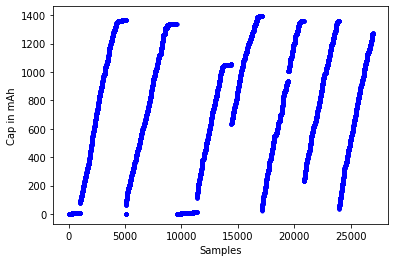

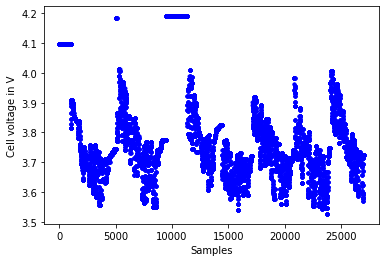

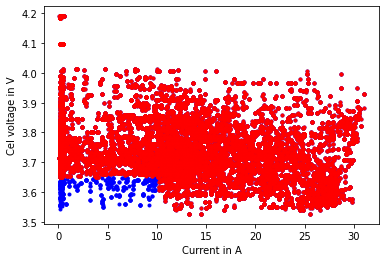

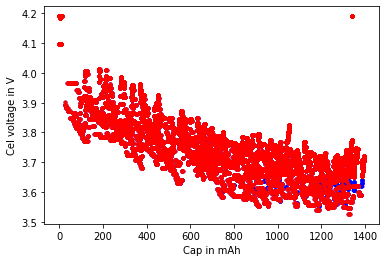

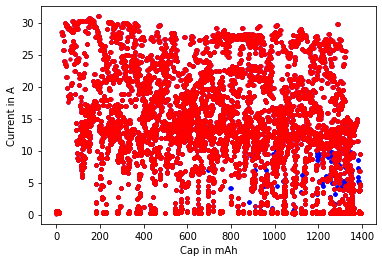

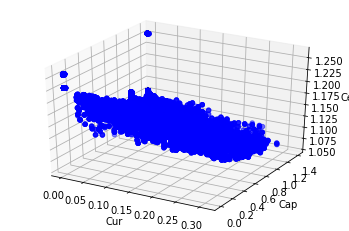

In [8]:
#select data for modelling
INDEX_START=2385
INDEX_STOP=5931
INDEX_START=1
INDEX_STOP=27000
SAMPLES=INDEX_STOP-INDEX_START

#scaling for telemetry data to get close to 1
SCALE_THR=1000
SCALE_CUR=100
SCALE_CAP=1000
SCALE_VOL=10
NUM_CEL=3
NOM_CAP=2200
SAMPLE_RATE=0.1

#throttle 
thr_values=df.iloc[INDEX_START:INDEX_STOP,9]
thr_values=thr_values.to_numpy()/SCALE_THR
print(thr_values)

#current
cur_values=df.iloc[INDEX_START:INDEX_STOP,5]
cur_values=cur_values.to_numpy()/SCALE_CUR 
print(cur_values)

#cap(mAh)
cap_values=df.iloc[INDEX_START:INDEX_STOP,6]
cap_values=cap_values.to_numpy()/SCALE_CAP 
print(cap_values)

#cels(V)
cel_values=df.iloc[INDEX_START:INDEX_STOP,4]
cel_values=cel_values.to_numpy()/SCALE_VOL 
print(cel_values)

CUR_MIN_LOW_VOL=10
VOL_MIN_LOW_CUR=3.65
skip_vec=np.linspace(1, 1, SAMPLES)
for i in range(SAMPLES):
  if cel_values[i]*SCALE_VOL/NUM_CEL<VOL_MIN_LOW_CUR and cur_values[i]*SCALE_CUR<CUR_MIN_LOW_VOL:
    skip_vec[i]=0

skip_vec = np.array(skip_vec,dtype='bool')

cur_values_clean=cur_values[skip_vec]
cap_values_clean=cap_values[skip_vec]
cel_values_clean=cel_values[skip_vec]

# Plot capacity
plt.plot(cap_values*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Plot voltage
plt.plot(cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cell voltage in V')
plt.show()


# Plot vol vs. cur
plt.plot(cur_values*SCALE_CUR, cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(cur_values_clean*SCALE_CUR, cel_values_clean*SCALE_VOL/NUM_CEL, 'r.')
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(cap_values*SCALE_CAP, cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, cel_values_clean*SCALE_VOL/NUM_CEL, 'r.')
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot Cap vs. cur
plt.plot(cap_values*SCALE_CAP, cur_values*SCALE_CUR, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, cur_values_clean*SCALE_CUR, 'r.')
plt.xlabel('Cap in mAh')
plt.ylabel('Current in A')
plt.show()

fig = plt.figure()
ax = plt.axes(projection="3d")
x = cur_values
y = cap_values
z = cel_values
ax.scatter(x,y,z,color='b')
ax.set_xlabel('Cur')
ax.set_ylabel('Cap')
ax.set_zlabel('Cel')
plt.show()

 
#shuffle data to avoid split of train,validate and test according to flight time
temp = list(zip(cur_values_clean, cap_values_clean, cel_values_clean)) 
np.random.shuffle(temp) 
cur_values_clean, cap_values_clean, cel_values_clean = zip(*temp)

cur_values_clean=np.array(cur_values_clean)
cap_values_clean=np.array(cap_values_clean)
cel_values_clean=np.array(cel_values_clean)

#define data for modelling
x_values=np.vstack((cur_values_clean,cap_values_clean))
x_values=np.transpose(x_values)
y_values=cel_values_clean


### 3. Split the Data
The data is split as follows:
Training: 60%
Validation: 20%
Testing: 20%

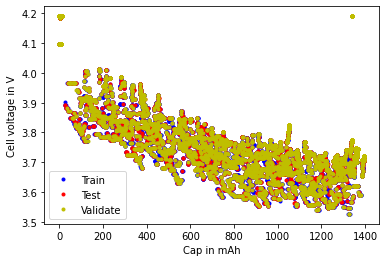

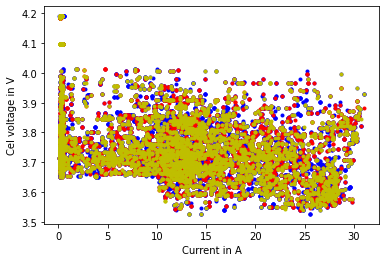

In [9]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
#x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#x_train=x_values[:,:TRAIN_SPLIT]
#x_test=x_values[:,TRAIN_SPLIT:TEST_SPLIT]
#x_validate=x_values[:,TEST_SPLIT:]

x_train=x_values[:TRAIN_SPLIT,:]
x_test=x_values[TRAIN_SPLIT:TEST_SPLIT,:]
x_validate=x_values[TEST_SPLIT:,:]

#y_train=y_values[:,:TRAIN_SPLIT]
#y_test=y_values[:,TRAIN_SPLIT:TEST_SPLIT]
#y_validate=y_values[:,TEST_SPLIT:]

# Plot vol vs. cap
plt.plot(x_train[:,1]*SCALE_CAP, y_train*SCALE_VOL/NUM_CEL, 'b.', label="Train")
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'r.', label="Test")
plt.plot(x_validate[:,1]*SCALE_CAP, y_validate*SCALE_VOL/NUM_CEL, 'y.', label="Validate")
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cur
plt.plot(x_train[:,0]*SCALE_CUR, y_train*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'r.', label="Test")
plt.plot(x_validate[:,0]*SCALE_CUR, y_validate*SCALE_VOL/NUM_CEL, 'y.', label="Validate")
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()






## Training



### 1. Design the model

We're going to build a simple neural network model that will take an input value (in this case throttle) and use it to predict a numeric output value (current). This type of problem is called a regression. It will use layers of neurons to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our x value) and runs it through 16 neurons. Based on this input, each neuron will become activated to a certain degree based on its internal state (its weight and bias values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our y value.

Note: To learn more about how neural networks function, you can explore the Learn TensorFlow codelabs.

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we compile it, specifying parameters that determine how it will be trained:

### Auto Tuner

In [69]:
#https://www.machinecurve.com/index.php/2020/06/09/automating-neural-network-configuration-with-keras-tuner/
#https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=uk

import kerastuner as kt
import IPython

# MODEL BUILDING FUNCTION
def model_builder1(hp):
  # Create the model
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(hp.Int('dense_lay1', min_value = 8, max_value = 128, step = 8), activation = 'relu',input_shape=(2,)))
  model.add(keras.layers.Dense(hp.Int('dense_lay2', min_value = 8, max_value = 128, step = 8), activation = 'relu'))
  model.add(keras.layers.Dense(hp.Int('dense_lay3', min_value = 8, max_value = 128, step = 8), activation = 'relu'))
  model.add(keras.layers.Dense(1))

  # Display a model summary
  model.summary()

  # Compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  
  # Return the model
  return model


In [71]:
tuner = kt.Hyperband(model_builder1,
                     objective = 'mae', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir13',
                     project_name = 'intro_to_kt')

# Display search space summary
tuner.search_space_summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________
Search space summary
Default search space size: 3
dense_lay1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dense_lay2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'st

In [19]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [72]:
#tuner.search(x_train, y_train, epochs = 10, validation_data = (x_validate, y_validate), callbacks = [ClearTrainingOutput()])
#best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

#print(f"""The hyperparameter search is complete. 
#The optimal number of units in the first densely-connected layer is {best_hps.get('dense_lay1')} 
#and for the second densely-connected layer is {best_hps.get('dense_lay2')}
#and for the thrird densely-connected layer is {best_hps.get('dense_lay3')}.""")

Trial 30 Complete [00h 00m 09s]
mae: 0.011945841833949089

Best mae So Far: 0.01148131862282753
Total elapsed time: 00h 02m 11s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 88 
and for the second densely-connected layer is 56
and for the thrird densely-connected layer is 24.


In [11]:
model1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model1.add(keras.layers.Dense(88, activation='relu', input_shape=(2,)))

# The new second and third layer will help the network learn more complex representations
model1.add(keras.layers.Dense(56, activation='relu'))
model1.add(keras.layers.Dense(24, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model1.compile(optimizer='adam', loss="mse", metrics=["mae"])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 88)                264       
_________________________________________________________________
dense_5 (Dense)              (None, 56)                4984      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1368      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________


In [64]:
#restore initial weights if required
#model1.set_weights(initial_weights1)

### auto-sklearn (model and train)

In [99]:
automl = autosklearn.regression.AutoSklearnRegressor(
  time_left_for_this_task=120,
  per_run_time_limit=30,
  tmp_folder='tmp/autosklearn_regression_example_tmp6',
  output_folder='tmp/autosklearn_regression_example_out6',
)

#x_train_2d=x_train.reshape(-1, 1)
y_train_2d=y_train.reshape(-1, 1)

automl.fit(x_train, y_train_2d, dataset_name='cur_thr_3')

print(automl.show_models())


/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  self.InputValidator.validate_target(y)
/usr/local/lib/python3.6/dist-packages/autosklearn/data/validation.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self.validate_target(y, is_classification)


[(0.740000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'random_forest', 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'False', 'feature_preprocessor:polynomial:interaction_only': 'True', 'regressor:random_forest:bootstrap': 'False', 'regressor:random_forest:criterion': 'mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 0.1686847993740384, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 1, 'regressor:ran

### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 200 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
#model1 = tuner.hypermodel.build(best_hps)
#history1 = model1.fit(x_train, y_train, epochs=100, batch_size=64,validation_data=(x_validate, y_validate))
#model1.summary()

#save initial weights
#initial_weights1 = model1.get_weights()

In [12]:
# Train the model
history1 = model1.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_validate, y_validate))

# Save the model to disk
model1.save(MODEL_TF)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
247/254 [============================>.] - ETA: 0s - loss: 0.2229 - mae: 0.3290

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
254/254 [==============================] - 1s 2ms/step - loss: 0.2181 - mae: 0.3230 - val_loss: 3.1624e-04 - val_mae: 0.0134
Epoch 2/100
254/254 [==============================] - 0s 2ms/step - loss: 2.8054e-04 - mae: 0.0125 - val_loss: 2.6825e-04 - val_mae: 0.0118
Epoch 3/100
254/254 [==============================] - 0s 2ms/step - loss: 2.4701e-04 - mae: 0.0115 - val_loss: 2.5827e-04 - val_mae: 0.0115
Epoch 4/100
254/254 [==============================] - 0s 2ms/step - loss: 2.5190e-04 - mae: 0.0114 - val_loss: 3.1414e-04 - val_mae: 0.0134
Epoch 5/100
254/254 [==============================] - 0s 2ms/step

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.au

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/model/assets


### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

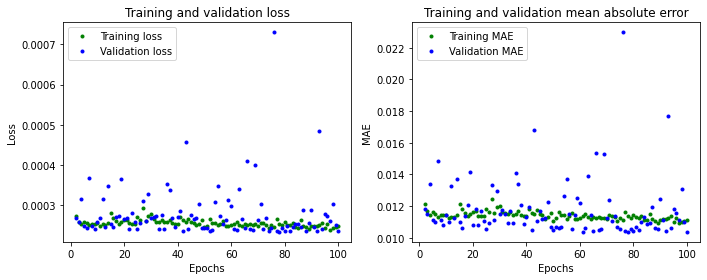

In [100]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 1

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history1.history['mae']
val_mae = history1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

169/169 [==============================] - 0s 953us/step - loss: 2.1011e-04 - mae: 0.0103
R2 score: 0.9049302346345727


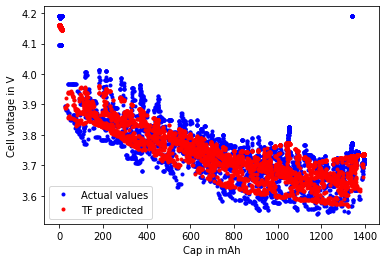

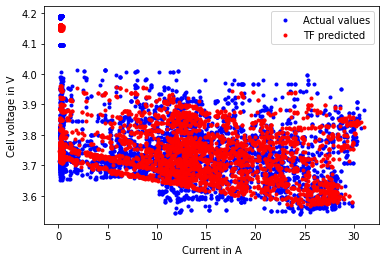

In [103]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model1.predict(x_test)

print("R2 score:", sklearn.metrics.r2_score(y_test, y_test_pred))

# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cell voltage in V')
plt.show()

R2 score: 0.9787938149176141


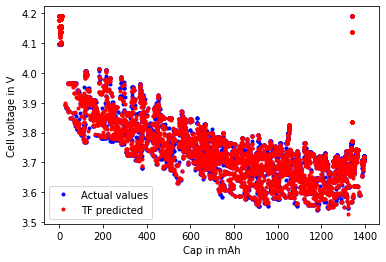

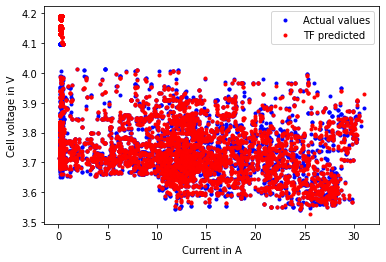

In [110]:
#auto-sklearn
y_test_2d=y_test.reshape(-1, 1)
y_test_pred = automl.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_test_pred))


# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cell voltage in V')
plt.show()

## Evaluate

the model can be used to predict the discharge curve and internal resistance
https://www.richtek.com/~/media/Richtek/Design%20Support/Technical%20Documentation/AN025/EN/Version3/image003.jpg?file=preview.png




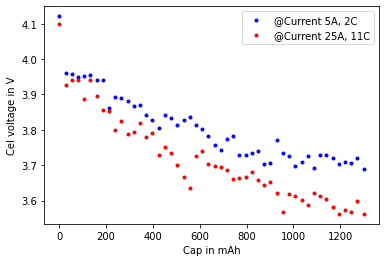

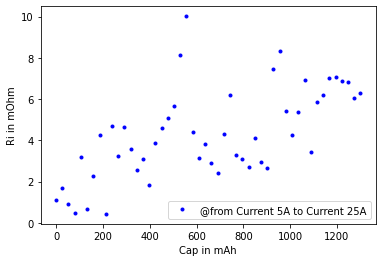

In [116]:
#current value 1
TEST_CUR1=5
TEST_SAMPLES1=50
TEST_CAP1=1300
cur_vec=np.linspace(TEST_CUR1, TEST_CUR1, TEST_SAMPLES1)/SCALE_CUR
cap_vec=np.linspace(0, TEST_CAP1, TEST_SAMPLES1)/SCALE_CAP
x_test_real1=np.vstack((cur_vec,cap_vec))
x_test_real1=np.transpose(x_test_real1)
#keras
y_test_real1 = model1.predict(x_test_real1)
#auto-sklearn
y_test_real1 = automl.predict(x_test_real1)

#current value 2
TEST_CUR2=25
TEST_SAMPLES2=50
TEST_CAP2=1300
cur_vec=np.linspace(TEST_CUR2, TEST_CUR2, TEST_SAMPLES2)/SCALE_CUR
cap_vec=np.linspace(0, TEST_CAP2, TEST_SAMPLES2)/SCALE_CAP
x_test_real2=np.vstack((cur_vec,cap_vec))
x_test_real2=np.transpose(x_test_real2)
#keras
y_test_real2 = model1.predict(x_test_real2)
#auto-sklearn
y_test_real2 = automl.predict(x_test_real2)

# Plot vol vs. cap
plt.plot(x_test_real1[:,1]*SCALE_CAP, y_test_real1*SCALE_VOL/NUM_CEL, 'b.', label='@Current '+str(TEST_CUR1)+'A, '+str(int(TEST_CUR1/NOM_CAP*1000)) +'C')
plt.plot(x_test_real2[:,1]*SCALE_CAP, y_test_real2*SCALE_VOL/NUM_CEL, 'r.', label='@Current '+str(TEST_CUR2)+'A, '+str(int(TEST_CUR2/NOM_CAP*1000)) +'C')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot Ri vs cap
y_ri=-(y_test_real2-y_test_real1)/(TEST_CUR2-TEST_CUR1)
plt.plot(x_test_real1[:,1]*SCALE_CAP, y_ri*SCALE_VOL/NUM_CEL*1000, 'b.', label='@from Current '+str(TEST_CUR1)+'A to Current '+str(TEST_CUR2)+'A')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Ri in mOhm')
plt.show()



# Drive model

## Dataset

### 1. Import Data

In [17]:
#import pandas as pd 
#import io 

#for local file upload instead of github
#df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 

#url1 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-11-28.csv'
#url2 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-12-05.csv'
#df1 = pd.read_csv(url1)
#df2 = pd.read_csv(url2)

df=df1
#df=df.append(df2)
print(df)



             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
16932  2020-11-28  18:27:36.930         0  ...  -1  0x0000000000000000      10.0
16933  2020-11-28  18:27:37.030         0  ...  -1  0x0000000000000000      10.0
16934  2020-11-28  18:27:37.130         0  ...  -1  0x0000000000000000      10.0
16935  2020-11-28  18:27:37.230         0  ...  -1  0x0000000000000000      10.0
16936  2020-11-28  18:27:37.330         0  ...  -1  0x0000000000000000      10.0

[16937 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [18]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


(16937, 26)

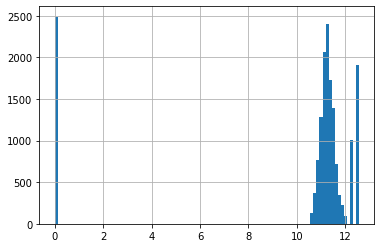

In [19]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWVOL=-5
HIGHVOL=16
ind_lowvol = df[df['Cels(V)'] < LOWVOL].index
df_nolowvol = df.drop(ind_lowvol, axis=0)

ind_highvol = df[df['Cels(V)'] > HIGHVOL].index
df_nolowvol_nohighvol = df_nolowvol.drop(ind_highvol, axis=0)

df_nolowvol_nohighvol['Cels(V)'].hist(bins=100)
df_nolowvol_nohighvol['Cels(V)'].describe()

df=df_nolowvol_nohighvol
np.shape(df)

(16937, 26)

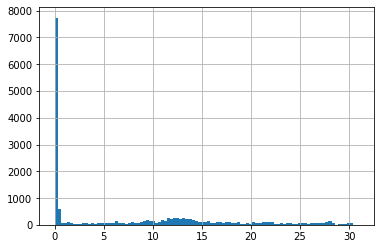

In [20]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWCUR=0
HIGHCUR=35
ind_lowcur = df[df['Curr(A)'] < LOWCUR].index
df_nolowcur = df.drop(ind_lowcur, axis=0)

ind_highcur = df[df['Curr(A)'] > HIGHCUR].index
df_nolowcur_nohighcur = df_nolowcur.drop(ind_highcur, axis=0)

df_nolowcur_nohighcur['Curr(A)'].hist(bins=100)
df_nolowcur_nohighcur['Curr(A)'].describe()

df=df_nolowcur_nohighcur
np.shape(df)


### 2. Select Data

[-1.022 -1.022 -1.022 ... -1.018 -1.018 -1.018]
[0.005 0.005 0.005 ... 0.002 0.002 0.002]
[0.007 0.007 0.008 ... 1.362 1.362 1.362]


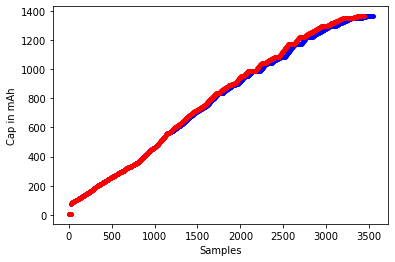

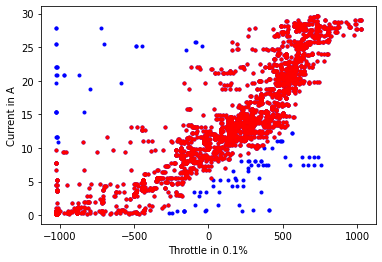

In [21]:
#select data for modelling
INDEX_START=2385
INDEX_STOP=5931
SAMPLES2=INDEX_STOP-INDEX_START

#scaling for telemetry data to get close to 1
#from battery model

#throttle 
thr_values=df.iloc[INDEX_START:INDEX_STOP,9]
thr_values=thr_values.to_numpy()/SCALE_THR
print(thr_values)

#current
cur_values=df.iloc[INDEX_START:INDEX_STOP,5]
cur_values=cur_values.to_numpy()/SCALE_CUR 
print(cur_values)

#cap(mAh)
cap_values=df.iloc[INDEX_START:INDEX_STOP,6]
cap_values=cap_values.to_numpy()/SCALE_CAP 
print(cap_values)

CUR_LIN_DEV_MAX=10
skip_vec=np.linspace(1, 1, SAMPLES2)
lin_vec=np.linspace(0, 0, SAMPLES2)
for i in range(SAMPLES2):
  lin_vec[i]=(max(cur_values)-min(cur_values))/(max(thr_values)-min(thr_values))*(thr_values[i]-min(thr_values))+min(cur_values)
  if abs(cur_values[i]-lin_vec[i])>CUR_LIN_DEV_MAX/SCALE_CUR:
    skip_vec[i]=0

skip_vec = np.array(skip_vec,dtype='bool')

thr_values_clean=thr_values[skip_vec]
cur_values_clean=cur_values[skip_vec]
cap_values_clean=cap_values[skip_vec]

# Plot capacity
plt.plot(cap_values*SCALE_CAP, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, 'r.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Plot current vs. throttle
plt.plot(thr_values*SCALE_THR, cur_values*SCALE_CUR, 'b.')
plt.plot(thr_values_clean*SCALE_THR, cur_values_clean*SCALE_CUR, 'r.')
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

#shuffle data to avoid split of train,validate and test according to flight time
temp = list(zip(thr_values_clean, cur_values_clean, cap_values_clean)) 
np.random.shuffle(temp) 
thr_values_clean, cur_values_clean, cap_values_clean = zip(*temp)

thr_values_clean=np.array(thr_values_clean)
cur_values_clean=np.array(cur_values_clean)
cap_values_clean=np.array(cap_values_clean)


#define data for modelling
#x_values=np.vstack((cur_values,cap_values))
#x_values=np.transpose(x_values)
x_values2=thr_values_clean
y_values2=cur_values_clean
y_sup_values2=cap_values_clean


### 3. Split the Data
The data is split as follows:
Training: 60%
Validation: 20%
Testing: 20%

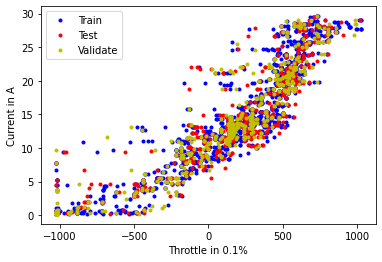

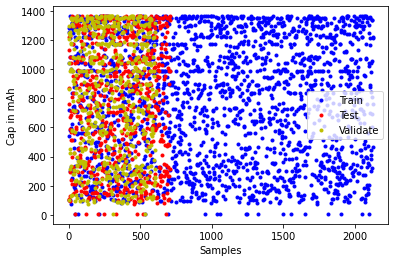

In [25]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES2)
TEST_SPLIT = int(0.2 * SAMPLES2 + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train2, x_test2, x_validate2 = np.split(x_values2, [TRAIN_SPLIT, TEST_SPLIT])
y_train2, y_test2, y_validate2 = np.split(y_values2, [TRAIN_SPLIT, TEST_SPLIT])
y_sup_train2, y_sup_test2, y_sup_validate2 = np.split(y_sup_values2, [TRAIN_SPLIT, TEST_SPLIT])


# Plot the data in each partition in different colors:
plt.plot(x_train2*SCALE_THR, y_train2*SCALE_CUR, 'b.', label="Train")
plt.plot(x_test2*SCALE_THR, y_test2*SCALE_CUR, 'r.', label="Test")
plt.plot(x_validate2*SCALE_THR, y_validate2*SCALE_CUR, 'y.', label="Validate")
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

# Plot capacity to check if data is scrambled and not ordered 
plt.plot(y_sup_train2*SCALE_CAP, 'b.', label="Train")
plt.plot(y_sup_test2*SCALE_CAP, 'r.', label="Test")
plt.plot(y_sup_validate2*SCALE_CAP, 'y.', label="Validate")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()



## Training

### 1. Design the model

### Auto Tuner

In [93]:
#https://www.machinecurve.com/index.php/2020/06/09/automating-neural-network-configuration-with-keras-tuner/
#https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=uk

import kerastuner as kt
import IPython

# MODEL BUILDING FUNCTION
def model_builder2(hp):
  # Create the model
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(hp.Int('dense_lay1', min_value = 8, max_value = 128, step = 8), activation = 'relu',input_shape=(1,)))
  model.add(keras.layers.Dense(hp.Int('dense_lay2', min_value = 8, max_value = 128, step = 8), activation = 'relu'))
  model.add(keras.layers.Dense(1))

  # Display a model summary
  model.summary()

  # Compile the model
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  
  # Return the model
  return model

In [94]:
tuner = kt.Hyperband(model_builder2,
                     objective = 'mae', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir14',
                     project_name = 'intro_to_kt')

# Display search space summary
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir14/intro_to_kt/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Search space summary
Default search space size: 2
dense_lay1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dense_lay2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}


In [91]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [95]:
#tuner.search(x_train2, y_train2, epochs = 10, validation_data = (x_validate2, y_validate2), callbacks = [ClearTrainingOutput()])
#best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

#print(f"""The hyperparameter search is complete. 
#The optimal number of units in the first densely-connected layer is {best_hps.get('dense_lay1')} 
#and for the second densely-connected layer is {best_hps.get('dense_lay2')}.""")

Trial 30 Complete [00h 00m 02s]
mae: 0.01707913726568222

Best mae So Far: 0.016942625865340233
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 56 
and for the second densely-connected layer is 56.


In [26]:
model2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model2.add(keras.layers.Dense(56, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model2.add(keras.layers.Dense(56, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model2.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model2.compile(optimizer='adam', loss="mse", metrics=["mae"])


In [23]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 56)                112       
_________________________________________________________________
dense_9 (Dense)              (None, 56)                3192      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 57        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


### auto-sklearn (model and train)

In [64]:
automl2 = autosklearn.regression.AutoSklearnRegressor(
  time_left_for_this_task=120,
  per_run_time_limit=30,
  tmp_folder='tmp/autosklearn_regression_example_tmp5',
  output_folder='tmp/autosklearn_regression_example_out5',
)

#x_train2_2d=x_train2.reshape(len(x_train2), 1)
#y_train2_2d=y_train2.reshape(len(y_train2), 1)
x_train2_2d=x_train2.reshape(-1, 1)
y_train2_2d=y_train2.reshape(-1, 1)

automl2.fit(x_train2_2d, y_train2_2d, dataset_name='cur_thr_3')

print(automl2.show_models())


/usr/local/lib/python3.6/dist-packages/autosklearn/automl.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  self.InputValidator.validate_target(y)
/usr/local/lib/python3.6/dist-packages/autosklearn/data/validation.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Will change shape via np.ravel().
  y = self.validate_target(y, is_classification)


[(0.720000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'random_forest', 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'True', 'feature_preprocessor:polynomial:interaction_only': 'False', 'regressor:random_forest:bootstrap': 'True', 'regressor:random_forest:criterion': 'friedman_mse', 'regressor:random_forest:max_depth': 'None', 'regressor:random_forest:max_features': 0.2961138557020546, 'regressor:random_forest:max_leaf_nodes': 'None', 'regressor:random_forest:min_impurity_decrease': 0.0, 'regressor:random_forest:min_samples_leaf': 14, 'regressor

### 2. Train the Model

In [27]:
# Train the model
history2 = model2.fit(x_train2, y_train2, epochs=200, batch_size=64,validation_data=(x_validate2, y_validate2))

# Save the model to disk
#model2.save(MODEL_TF)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/34 [..............................] - ETA: 11s - loss: 0.0160 - mae: 0.1134

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: smac attempted to use a functionality that requires module emcee, but it couldn't be loaded. Please install emcee and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
34/34 [==============================] - 1s 6ms/step - loss: 0.0054 - mae: 0.0552 - val_loss: 8.9589e-04 - val_mae: 0.0210
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 7.0181e-04 - mae: 0.0187 - val_loss: 7.1176e-04 - val_mae: 0.0183
Epoch 3/200
34/34 [==============================] - 0s 2ms/step - loss: 6.2069e-04 - mae: 0.0174 - val_loss: 6.9768e-04 - val_mae: 0.0185
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 6.0591e-04 - mae: 0.0168 - val_loss: 6.9277e-04 - val_mae: 0.0174
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 6

### 3. Plot Metrics

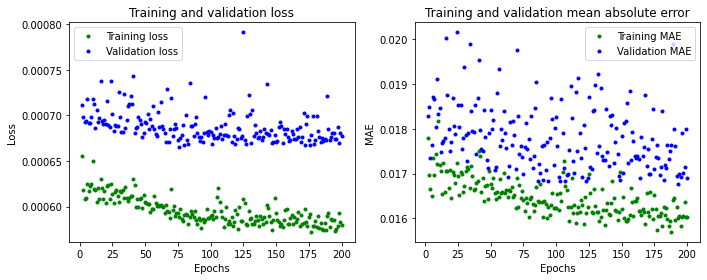

In [61]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 1

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history2.history['mae']
val_mae = history2.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

23/23 [==============================] - 0s 1ms/step - loss: 7.0693e-04 - mae: 0.0171
R2 score: 0.8870242079626682


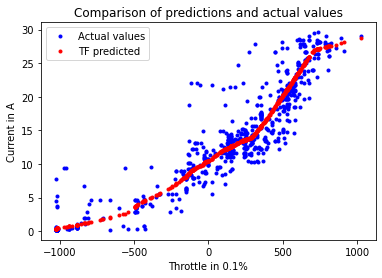

In [62]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model2.evaluate(x_test2, y_test2)

# Make predictions based on our test dataset
y_test2_pred = model2.predict(x_test2)

print("R2 score:", sklearn.metrics.r2_score(y_test2, y_test2_pred))

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test2*SCALE_THR, y_test2*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_test2*SCALE_THR, y_test2_pred*SCALE_CUR, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

R2 score: 0.8922220850428819


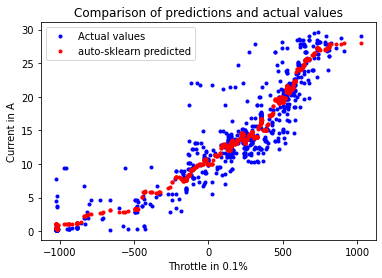

In [102]:
#auto-sklearn
x_test2_2d=x_test2.reshape(-1, 1)
y_test2_2d=y_test2.reshape(-1, 1)
y_test2_pred = automl2.predict(x_test2_2d)
print("R2 score:", sklearn.metrics.r2_score(y_test2_2d, y_test2_pred))

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test2*SCALE_THR, y_test2*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_test2*SCALE_THR, y_test2_pred*SCALE_CUR, 'r.', label='auto-sklearn predicted')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

## Evaluate

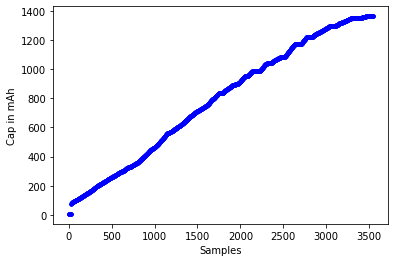

In [66]:
# my log file contained several flights
#fligth2
INDEX_START=6610
INDEX_STOP=10510

#fligth3
INDEX_START=13006
INDEX_STOP=15521

#fligth1
INDEX_START=2385
INDEX_STOP=5931

#throttle 
x_real2=df.iloc[INDEX_START:INDEX_STOP,9]
x_real2=x_real2.to_numpy()/1000 
#print(x_values)

#current
y_real2=df.iloc[INDEX_START:INDEX_STOP,5]
y_real2=y_real2.to_numpy()/100 
#print(y_values)

#cap(mAh)
y_real22=df.iloc[INDEX_START:INDEX_STOP,6]
y_real22=y_real22.to_numpy()/1000 
#print(y_values2)

# Plot capacity
plt.plot(y_real22*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

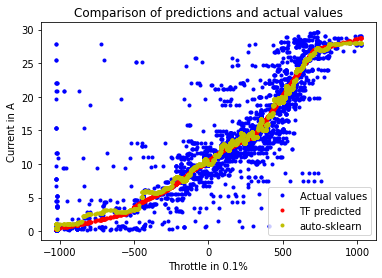

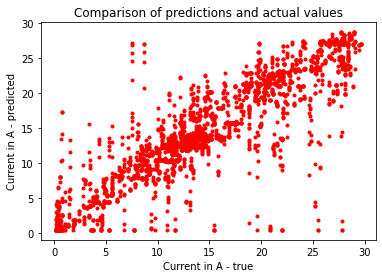

In [71]:
# Make predictions based on our test dataset
y_real_pred2 = model2.predict(x_real2)

x_real2_2d=x_real2.reshape(-1, 1)
y_real_pred22 = automl2.predict(x_real2_2d)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_real2*SCALE_THR, y_real2*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_real2*SCALE_THR, y_real_pred2*SCALE_CUR, 'r.', label='TF predicted')
plt.plot(x_real2*SCALE_THR, y_real_pred22*SCALE_CUR, 'y.', label='auto-sklearn')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

plt.title('Comparison of predictions and actual values')
plt.plot(y_real2*SCALE_CUR, y_real_pred2*SCALE_CUR, 'r.')
plt.xlabel('Current in A - true')
plt.ylabel('Current in A - predicted')
plt.show()

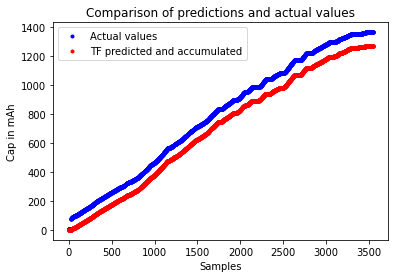

In [103]:
# integrate current
# offset errors are due to logging only during flight phase (not during take-off)
y_real_pred22=np.cumsum(y_real_pred2)*SAMPLE_RATE*1000/3600*SCALE_CUR/SCALE_CAP

plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(y_real22*SCALE_CAP, 'b.', label='Actual values')
plt.plot(y_real_pred22*SCALE_CAP, 'r.', label='TF predicted and accumulated')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Emulate

In [155]:
#initial condition
INDEX_START=2450
#INDEX_STOP=5931

#INDEX_START=6700
INDEX_STOP=10510

INDEX_START=4000
INDEX_STOP=8000

INDEX_START=2450
INDEX_STOP=5931


SAMPLES_EMU=INDEX_STOP-INDEX_START

CELL_VOL_CRITICAL=3.5
CELL_VOL_PENALITY_THRESHOLD=-0.5

time_vec=np.linspace(0, 0, SAMPLES_EMU)
#throttle controlls the emulation
thr_vec=np.linspace(0, 0, SAMPLES_EMU)
#current is predicted by model2
curr_vec=np.linspace(0, 0, SAMPLES_EMU)
curr_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
#cap is calulcated by integrated current
cap_vec=np.linspace(0, 0, SAMPLES_EMU)
cap_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
#cel voltage is predicted by model1
vol_vec=np.linspace(0, 0, SAMPLES_EMU)
vol_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
cell_vol_error=np.linspace(0, 0, SAMPLES_EMU)
cell_vol_penality=np.linspace(0, 0, SAMPLES_EMU)
curate=np.linspace(0, 0, SAMPLES_EMU)


In [156]:
# using a 'for loop' to clearly avoid any future knowledge during prediction
# takes several minutes (why?)

#single vale as 2S array for auto-sklearn model
#single_value_array=np.array([0.2])
#single_value_array=single_value_array.reshape(-1, 1)
#automl2.predict(single_value_array).item()*SCALE_CUR

#double_value_array=np.vstack((np.array(0),np.array(0)))
#double_value_array=np.transpose(double_value_array)
#automl.predict(double_value_array).item()

USE_AUTO_SK_LEARN=1
USE_KERAS=0

time_vec[0]=0
thr_vec[0]=df.iloc[INDEX_START+0,9]/SCALE_THR
curr_vec_gt[0]=df.iloc[INDEX_START+0,5]/SCALE_CUR
if USE_KERAS:
  curr_vec[0]=model2.predict([thr_vec[0]]).item()
if USE_AUTO_SK_LEARN:
  single_value_array=np.array([thr_vec[0]])
  single_value_array=single_value_array.reshape(-1, 1)
  curr_vec[0]=automl2.predict(single_value_array).item()*SCALE_CUR
cap_vec_gt[0]=df.iloc[INDEX_START+0,6]/SCALE_CAP
# initial value must be given
cap_vec[0]=df.iloc[INDEX_START+0,6]/SCALE_CAP
vol_vec_gt[0]=df.iloc[INDEX_START+0,4]/SCALE_VOL
if USE_KERAS:
  vol_vec[0]=model1.predict([[curr_vec[0],cap_vec[0]]]).item()
if USE_AUTO_SK_LEARN:
  double_value_array=np.vstack((np.array(curr_vec[0]),np.array(cap_vec[0])))
  double_value_array=np.transpose(double_value_array)
  vol_vec[0]=automl.predict(double_value_array).item()
curate[0]=0
print('total samples: '+str(SAMPLES_EMU))

for i in range(1,SAMPLES_EMU):
  time_vec[i]=time_vec[i-1]+SAMPLE_RATE
  thr_vec[i]=df.iloc[INDEX_START+i,9]/SCALE_THR
  curr_vec_gt[i]=df.iloc[INDEX_START+i,5]/SCALE_CUR
  if keras_model:
    curr_vec[i]=model2.predict([thr_vec[i]]).item()
  if auto_sklearn_model:
    single_value_array=np.array([thr_vec[i]])
    single_value_array=single_value_array.reshape(-1, 1)
    curr_vec[i]=automl2.predict(single_value_array).item()*SCALE_CUR
  #curr_vec[i]=model2.predict([thr_vec[i]]).item()
  cap_vec_gt[i]=df.iloc[INDEX_START+i,6]/SCALE_CAP
  cap_vec[i]=cap_vec[i-1]+curr_vec[i]*SAMPLE_RATE*1000/3600*SCALE_CUR/SCALE_CAP
  #required to detect new flight
  if abs(cap_vec_gt[i]-cap_vec_gt[i-1])>50/SCALE_CAP:
    cap_vec[i]=cap_vec_gt[i]
  vol_vec_gt[i]=df.iloc[INDEX_START+i,4]/SCALE_VOL
  if keras_model:
    vol_vec[i]=model1.predict([[curr_vec[i],cap_vec[i]]]).item()
  if auto_sklearn_model:
    double_value_array=np.vstack((np.array(curr_vec[i]),np.array(cap_vec[i])))
    double_value_array=np.transpose(double_value_array)
    vol_vec[i]=automl.predict(double_value_array).item()
  #vol_vec[i]=model1.predict([[curr_vec[i],cap_vec[i]]]).item()
  cell_vol_error[i]=(vol_vec_gt[i]*SCALE_VOL/NUM_CEL-vol_vec[i]*SCALE_VOL/NUM_CEL)
  cell_vol_penality[i]=cell_vol_error[i]*1/(vol_vec_gt[i]*SCALE_VOL/NUM_CEL-CELL_VOL_CRITICAL)
  if cell_vol_penality[i]<CELL_VOL_PENALITY_THRESHOLD:
    curate[i]=1
  if i%100==0:
    print (i)




total samples: 3481
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


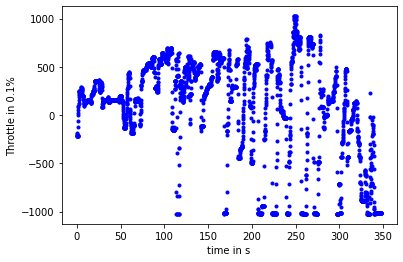

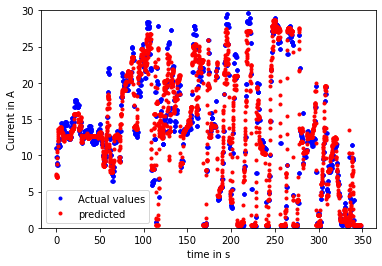

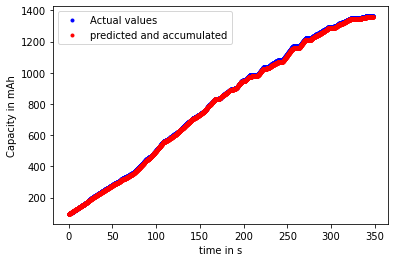

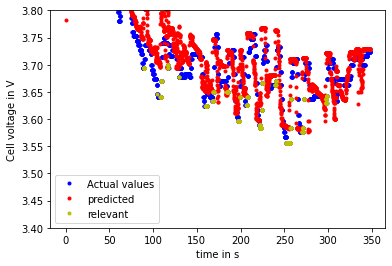

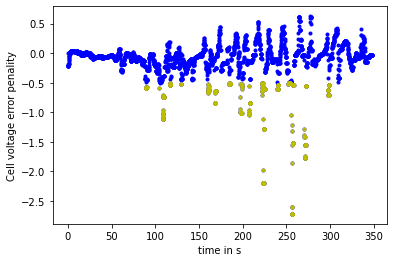

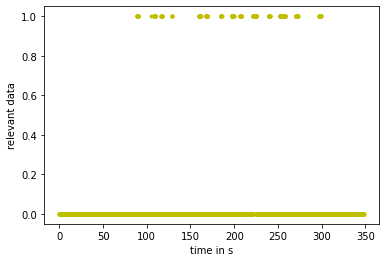

In [158]:
plt.clf()
plt.plot(time_vec,thr_vec*SCALE_THR, 'b.', label='Actual values')
plt.xlabel('time in s')
plt.ylabel('Throttle in 0.1%')
plt.show()

plt.clf()
plt.plot(time_vec,curr_vec_gt*SCALE_CUR, 'b.', label='Actual values')
plt.plot(time_vec,curr_vec*SCALE_CUR, 'r.', label='predicted')
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Current in A')
plt.ylim(0, 30)
plt.show()

plt.clf()
plt.plot(time_vec,cap_vec_gt*SCALE_CAP, 'b.', label='Actual values')
plt.plot(time_vec,cap_vec*SCALE_CAP, 'r.', label='predicted and accumulated')
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Capacity in mAh')
plt.show()

plt.clf()
plt.plot(time_vec,vol_vec_gt*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(time_vec,vol_vec*SCALE_VOL/NUM_CEL, 'r.', label='predicted')
plt.plot(time_vec[curate>0],vol_vec_gt[curate>0]*SCALE_VOL/NUM_CEL, 'y.', label='relevant')
plt.ylim(3.4, 3.8)
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Cell voltage in V')
plt.show()

plt.clf()
plt.plot(time_vec,cell_vol_penality, 'b.')
plt.plot(time_vec[curate>0],cell_vol_penality[curate>0], 'y.')
plt.xlabel('time in s')
plt.ylabel('Cell voltage error penality')
plt.show()

plt.clf()
plt.plot(time_vec,curate, 'y.')
plt.xlabel('time in s')
plt.ylabel('relevant data')
plt.show()

# Data Curation


penality sum: -297


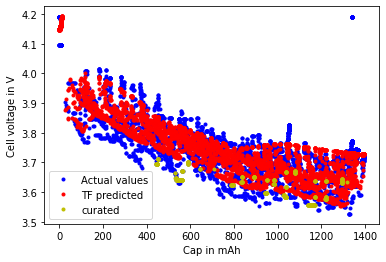

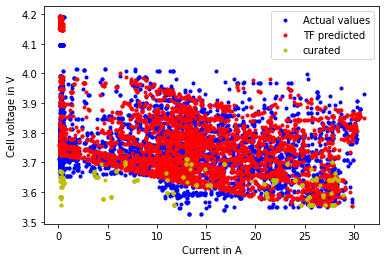

In [107]:
print('penality sum:',str(int(sum(cell_vol_penality[curate>0]))))
curate = np.array(curate,dtype='bool')

thr_vec_relevant=thr_vec[curate]
curr_vec_gt_relevant=curr_vec_gt[curate]
cap_vec_gt_relevant=cap_vec_gt[curate]
vol_vec_gt_relevant=vol_vec_gt[curate]

# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.plot(cap_vec_gt_relevant*SCALE_CAP, vol_vec_gt_relevant*SCALE_VOL/NUM_CEL, 'y.', label='curated')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.plot(curr_vec_gt_relevant*SCALE_CUR, vol_vec_gt_relevant*SCALE_VOL/NUM_CEL, 'y.', label='curated')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cell voltage in V')
plt.show()


In [37]:
#define data for modelling

cur_values_curate=cur_values
cap_values_curate=cap_values
cel_values_curate=cel_values

cur_values_curate=np.append(cur_values_curate,curr_vec_gt_relevant)
cap_values_curate=np.append(cap_values_curate,cap_vec_gt_relevant)
cel_values_curate=np.append(cel_values_curate,vol_vec_gt_relevant)

x_values=np.vstack((cur_values_curate,cap_values_curate))
x_values=np.transpose(x_values)
y_values=cel_values_curate